In [1]:
%matplotlib inline

In [2]:
import datetime
import numpy as np 
import pandas as pd 
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.metrics import roc_auc_score
from sklearn.learning_curve import learning_curve
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.grid_search import GridSearchCV

import xgboost as xgb
import matplotlib.pyplot as plt
import prettyplotlib as ppl
import brewer2mpl
import random
from operator import itemgetter
import time
import copy

In [3]:
set2 = brewer2mpl.get_map('Set2', 'qualitative', 8).mpl_colors

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 16,
        }
plt.rc('font',family='serif')
plt.rc('font', size=16)
plt.rc('font', weight='bold')
plt.style.use('fivethirtyeight')
    
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 6 and height to 6
fig_size[0] = 6
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

### Load Data

In [4]:
train = pd.read_csv('data/act_train.csv', dtype={'people_id': np.str,
                               'activity_id': np.str,
                               'outcome': np.int8}, parse_dates=['date'])
test = pd.read_csv('data/act_test.csv', dtype={'people_id': np.str,
                              'activity_id': np.str}, parse_dates=['date'])
people = pd.read_csv('data/people.csv', dtype={'people_id': np.str,
                              'activity_id': np.str,
                              'char_38': np.int32},parse_dates=['date'])

### Cleanup Data - Date, FillNaN etc

In [5]:
def date_to_julian_day(row):
    """Returns the Julian day number of a date."""
    date_format = '%m/%d%Y'
    recorded_date = row['date']
    a = (14 - recorded_date.month)//12
    y = recorded_date.year + 4800 - a
    m = recorded_date.month + 12*a - 3
    return (recorded_date.day + ((153*m + 2)//5) + 365*y + y//4 - y//100 + y//400 - 320450)**0.5

In [6]:
print("Process tables...")
for table in [train, test]:
        table['year'] = table['date'].dt.year
        table['month'] = table['date'].dt.month
        table['day'] = table['date'].dt.day
        table['julian'] = table.apply(date_to_julian_day, axis=1)
        table.drop('date', axis=1, inplace=True)
        table['activity_category'] = table['activity_category'].str.lstrip('type ').astype(np.int32)
        for i in range(1, 11):
            table['char_' + str(i)].fillna('type -999', inplace=True)
            table['char_' + str(i)] = table['char_' + str(i)].str.lstrip('type ').astype(np.int32)
people['year'] = people['date'].dt.year
people['month'] = people['date'].dt.month
people['day'] = people['date'].dt.day
people['julian'] = people.apply(date_to_julian_day, axis=1)
people.drop('date', axis=1, inplace=True)
people['group_1'] = people['group_1'].str.lstrip('group ').astype(np.int32)
for i in range(1, 10):
        people['char_' + str(i)] = people['char_' + str(i)].str.lstrip('type ').astype(np.int32)
for i in range(10, 38):
        people['char_' + str(i)] = people['char_' + str(i)].astype(np.int32)

print("Merge...")
train = pd.merge(train, people, how='left', on='people_id', left_index=True)
train.fillna(-999, inplace=True)
test = pd.merge(test, people, how='left', on='people_id', left_index=True)
test.fillna(-999, inplace=True)

Process tables...
Merge...


## Code for Data Leak !

In [11]:
train_1 = train[['activity_id', 'group_1', 'julian_x', 'outcome']]
test_1 = test[['activity_id', 'group_1', 'julian_x']]

In [12]:
merge = pd.merge(train_1, test_1, how='inner', 
                         on=['group_1', 'julian_x'], left_index=True)

In [14]:
print(train.people_id.count())
print("")
print(test.people_id.count())
print("")
print(merge.activity_id_x.count())

2197291

498687

563715349


In [15]:
print(merge.head())

     activity_id_x  group_1     julian_x  outcome activity_id_y
970   act2_1734928    17304  1473.695355        0   act2_995854
1947  act2_1734928    17304  1473.695355        0  act2_1191412
1947  act2_1734928    17304  1473.695355        0  act2_3108317
2607  act2_1734928    17304  1473.695355        0  act2_1281350
2607  act2_1734928    17304  1473.695355        0  act2_1923599


In [16]:
merge.drop('activity_id_x', axis=1, inplace=True)

In [18]:
merge.columns

Index(['group_1', 'julian_x', 'outcome', 'activity_id_y'], dtype='object')

In [19]:
merge.drop('group_1', axis=1, inplace=True)

In [20]:
merge.drop('julian_x', axis=1, inplace=True)

In [21]:
merge.columns = ['outcome', 'activity_id']

In [22]:
merge.head()

,outcome,activity_id
970,0,act2_995854
1947,0,act2_1191412
1947,0,act2_3108317
2607,0,act2_1281350
2607,0,act2_1923599


In [37]:
merge1 = merge.groupby(['activity_id'])['outcome'].mean()

In [38]:
merge1 = merge1.to_frame()
merge1.reset_index(level=0, inplace=True)

In [40]:
merge = merge1[['activity_id','outcome']]

In [41]:
merge.head()

,activity_id,outcome
0,act1_1,1
1,act1_100006,0
2,act1_100065,0
3,act1_100068,0
4,act1_100100,0


In [42]:
print(test.activity_id.count())

498687


### Remove all activity id's in test which is already in merge

In [43]:
test = test[~test['activity_id'].isin(merge['activity_id'])]

In [44]:
print(test.activity_id.count())

206698


## End of Code for Data Leak !

### Select Features for Model

In [52]:
feature_cols = [col for col in train.columns if col not in ['people_id', 'activity_id','outcome']]
target = 'outcome'

In [53]:
print('Length of train: ', len(train))
print('Length of test: ', len(test))
print('Features [{}]: {}'.format(len(feature_cols), sorted(feature_cols)))


Length of train:  2197291
Length of test:  206698
Features [58]: ['activity_category', 'char_10_x', 'char_10_y', 'char_11', 'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17', 'char_18', 'char_19', 'char_1_x', 'char_1_y', 'char_20', 'char_21', 'char_22', 'char_23', 'char_24', 'char_25', 'char_26', 'char_27', 'char_28', 'char_29', 'char_2_x', 'char_2_y', 'char_30', 'char_31', 'char_32', 'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38', 'char_3_x', 'char_3_y', 'char_4_x', 'char_4_y', 'char_5_x', 'char_5_y', 'char_6_x', 'char_6_y', 'char_7_x', 'char_7_y', 'char_8_x', 'char_8_y', 'char_9_x', 'char_9_y', 'day_x', 'day_y', 'group_1', 'julian_x', 'julian_y', 'month_x', 'month_y', 'year_x', 'year_y']


In [54]:
feature_cols = ['group_1', 'char_38', 'char_7_y', 'char_6_y', 'char_9_y', 'char_8_y', 'char_3_y', 'char_10_y', 'julian_x', 'julian_y']

### Function to Model ROC

In [55]:
def plot_roc(model, title):
    model.fit(X_train, y_train)
    actuals = y_train
    predictions  = model.predict(X_train)
    
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(actuals, predictions)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    
    actuals_t = y_test
    predictions_t  = model.predict(X_test)
    false_positive_rate_t, true_positive_rate_t, thresholds_t = metrics.roc_curve(actuals_t, predictions_t)
    roc_auc_t = metrics.auc(false_positive_rate_t, true_positive_rate_t)

    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive_rate, true_positive_rate, 'r', label='Training = %0.2f'% roc_auc)
    plt.plot(false_positive_rate_t, true_positive_rate_t, 'g', label='Test = %0.2f'% roc_auc_t)
    plt.fill(false_positive_rate, true_positive_rate, facecolor='blue', alpha=0.5, )
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontdict=font)
    plt.ylabel('True Positive Rate', fontdict=font)
    title = "Redhat Dataset " + title
    plt.title(title, fontdict=font)
    plt.legend(loc="lower right", fontsize=20)
    #plt.savefig(name, bbox_inches='tight')
    plt.show()
    return roc_auc 

In [56]:
def plot_learning_curve(estimator, title, ylim=None):
    
    train_sizes=np.linspace(.1, 1.0, 5)
    cv=None
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    title = "RedHat Dataset - " + title
    plt.title(title, y=1.08, fontdict=font)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples", fontdict=font)
    plt.ylabel("Score", fontdict=font)
    plt.grid(True)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.plot(train_sizes, train_scores_mean, color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, color="g",
             label="Cross-validation score")
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

In [57]:
X = train[feature_cols]
Xt = test[feature_cols]
y = train['outcome']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

(1757832, 10)
(1757832,)


### Random Forest & XgBoost Model

In [68]:
model = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0,
            warm_start=False)
model2 = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=6,
       min_child_weight=2, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

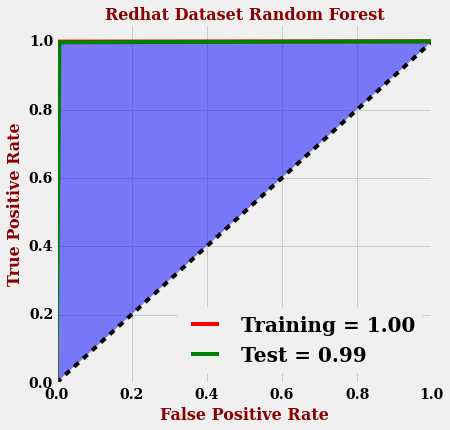

0.99816199537213524

In [60]:
plot_roc(model, 'Random Forest')

In [61]:
from sklearn import cross_validation
scores = cross_validation.cross_val_score(model, X, y, n_jobs=-1, scoring="roc_auc", cv=5)
print(scores)
print("")
print(sum(scores)/len(scores))

[ 0.97001519  0.95837803  0.971428    0.95306796  0.96277723]

0.963133283258


In [62]:
model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

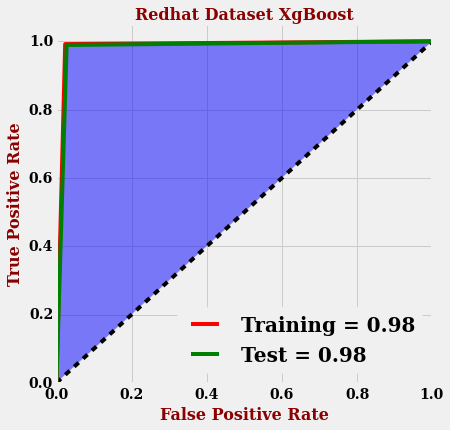

0.98433305016280925

In [69]:
plot_roc(model2, 'XgBoost')

In [70]:
model2.fit(X,y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=6,
       min_child_weight=2, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [71]:
model_vc = ensemble.VotingClassifier(estimators= [('rf', model), ('xgb', model2)], voting='soft')

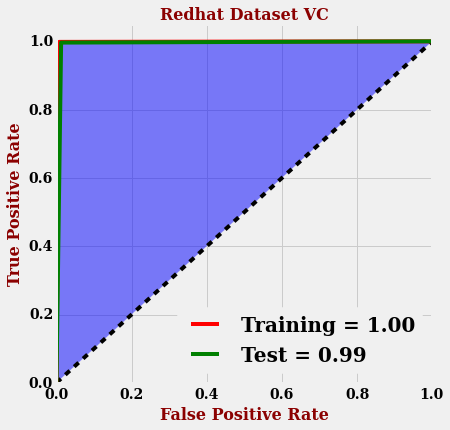

0.9954760983168226

In [72]:
plot_roc(model_vc, "VC")

In [73]:
model_vc.fit(X,y)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
        ...gistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8))],
         voting='soft', weights=None)

In [75]:
y_predict = model_vc.predict_proba(Xt)

In [76]:
yPred = y_predict[:,1]

In [77]:
current_time = datetime.datetime.now()

In [78]:
sub = pd.DataFrame()
sub['activity_id'] = test['activity_id']
sub['outcome'] = yPred.tolist()

In [79]:
sub.count()

activity_id    206698
outcome        206698
dtype: int64

In [80]:
merge.count()

activity_id    291989
outcome        291989
dtype: int64

In [82]:
sub = pd.concat([sub, merge])

In [83]:
sub.count()

activity_id    498687
outcome        498687
dtype: int64

In [84]:
sub.to_csv('submission_vc_dataleak_' + str(current_time.strftime("%Y-%m-%d-%H-%M")) + '.csv', index=False)